# By: Thomas Isola
## Class: PUI 2018
## HW #8 Assignment 2

In [1]:
# Import packages
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import scipy.stats

%pylab inline

# Check for existence of PUIDATA environmental variable
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

Populating the interactive namespace from numpy and matplotlib


**IDEA**: Younger citibike users ride longer duration trips, on average, compared to older citibike users.

**Null Hypothesis**: Bikers under the age of 30 ride shorter duration or equal duration trips, on average, compared to bikers over the age of 30.  
(Avg ride duration, under 30) <= (Avg ride duration, over 30)

**Alternative Hypothesis**: Bikers under the age of 30 ride longer duration trips, on average, compared to bikers over the age of 30.  
(Avg ride duration, under 30) > (Avg ride duration, over 30)

I will use a confidence level of *alpha* = 0.05

In [2]:
# Assign the alpha level to a variable
alpha = 0.05

In [3]:
# Download the data
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    # Check if file is already there or not
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [4]:
# Set date desired to download
datestring1 = '201501'
getCitiBikeCSV(datestring1)

file in place, you can continue


In [5]:
# Download another month of data to eliminate seasonal effects
datestring2 = '201507'
getCitiBikeCSV(datestring2)

file in place, you can continue


In [6]:
# Read the CSV data using Pandas and concatenate the two months of data
bikeData1 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring1 + '-citibike-tripdata.csv')
bikeData2 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')
bikeData = pd.concat([bikeData1,bikeData2], ignore_index=True)

In [7]:
# Display the head of the data
bikeData.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [8]:
# Display the columns of the data
bikeData.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [9]:
# Drop the columns that are not relevant to test the hypothesis
bikeData.drop(['starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'gender'], axis=1, inplace=True)

In [10]:
# Show the reduced data
bikeData.head()

,tripduration,birth year
0,1346,1960.0
1,363,1963.0
2,346,1974.0
3,182,1969.0
4,969,1977.0


In [11]:
# Remove unusable data (data where NaN is displayed)
bikeData3 = bikeData.dropna()

# Filter to split data for users above and below 30 years old
bikeData_younger = bikeData3.loc[bikeData3['birth year']>=1988.0]
bikeData_older = bikeData3.loc[bikeData3['birth year']<1988.0]

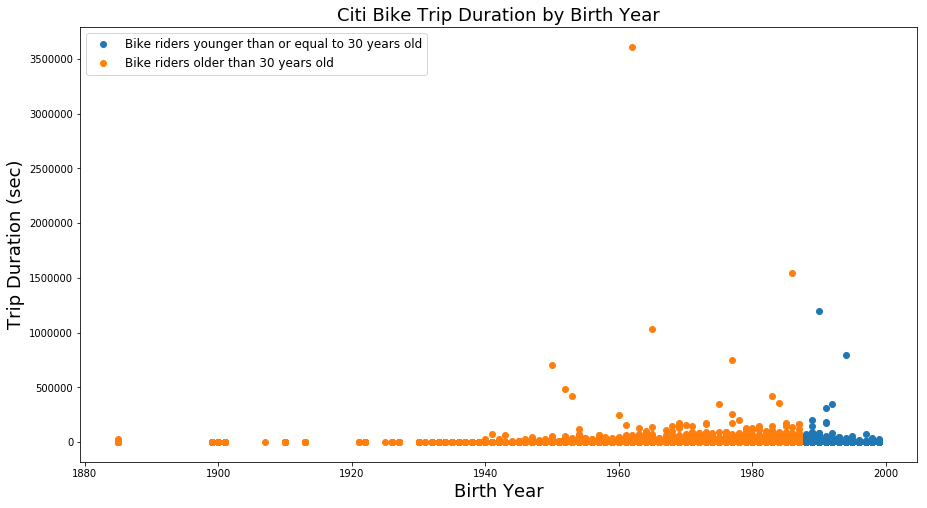

In [12]:
# Plot the data
bikePlot = pl.figure(figsize=(15,8)).add_subplot(111)

bikePlot.set_xlabel('Birth Year', fontsize=18)
bikePlot.set_ylabel('Trip Duration (sec)', fontsize=18)
bikePlot.set_title('Citi Bike Trip Duration by Birth Year', fontsize=18)
bikePlot.plot(bikeData_younger['birth year'],bikeData_younger['tripduration'],'o',label="Bike riders younger than or equal to 30 years old")
bikePlot.plot(bikeData_older['birth year'],bikeData_older['tripduration'],'o',label="Bike riders older than 30 years old")
bikePlot.legend(fontsize=12)

**Figure 1**: A scatter plot of trip duration for each individual trip for Citi Bike users in January and July 2015. The plot distinguishes between riders that are younger than 30 years old and riders that are older than 30 years old. As shown in the plot above, there are outliers that are distorting the plot. Therefore, I will proceed to remove the outlier data and re-plot the data.

In [22]:
# Filter out bike trips longer than 4 hours
bikeData_younger = bikeData_younger[bikeData_younger.tripduration<14400]
bikeData_older = bikeData_older[bikeData_older.tripduration<14400]
bikeData_younger.reset_index();
bikeData_older.reset_index();

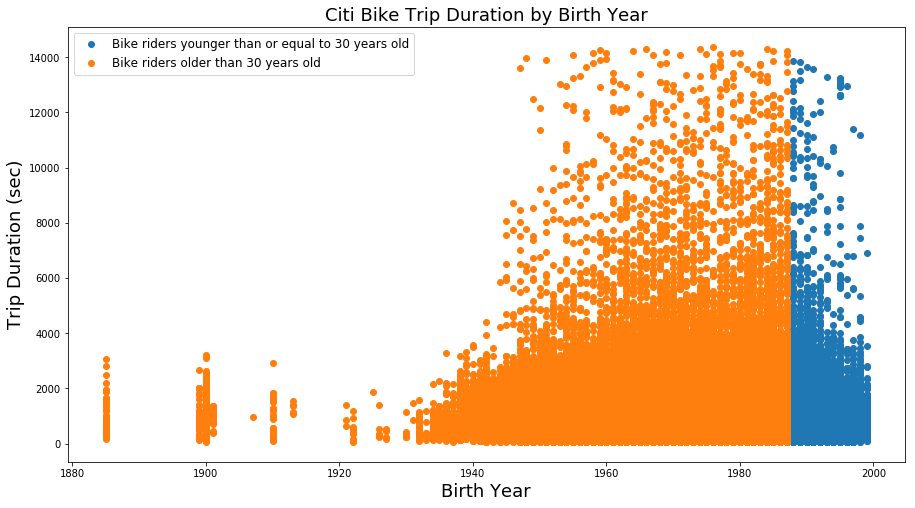

In [14]:
# Plot the edited data
bikePlot2 = pl.figure(figsize=(15,8)).add_subplot(111)

bikePlot2.set_xlabel('Birth Year', fontsize=18)
bikePlot2.set_ylabel('Trip Duration (sec)', fontsize=18)
bikePlot2.set_title('Citi Bike Trip Duration by Birth Year', fontsize=18)
bikePlot2.plot(bikeData_younger['birth year'],bikeData_younger['tripduration'],'o',label="Bike riders younger than or equal to 30 years old")
bikePlot2.plot(bikeData_older['birth year'],bikeData_older['tripduration'],'o',label="Bike riders older than 30 years old")
bikePlot2.legend(fontsize=12)

**Figure 2**: A scatter plot of trip duration for each individual trip for Citi Bike users in January and July 2015, with outliers removed. The plot distinguishes between riders that are younger than 30 years old and riders that are older than 30 years old.

In [18]:
# Perform the t-test
print("The mean trip duration for younger Citibike riders is %s seconds" %bikeData_younger.tripduration.mean())
print("The mean trip duration for older Citibike riders is %s seconds" %bikeData_older.tripduration.mean())

The mean trip duration for younger Citibike riders is 697.082551424 seconds
The mean trip duration for older Citibike riders is 724.455640624 seconds


In [16]:
theTTest = scipy.stats.ttest_ind(bikeData_younger.tripduration,bikeData_older.tripduration)

In [17]:
# Determine if the null hypothesis is rejected
if(theTTest.pvalue<alpha):
    print("The null hypothesis is rejected. The means of the two samples, younger and older riders, are significantly different.")
else:
    print("The null hypothesis cannot be rejected.")

The null hypothesis is rejected. The means of the two samples, younger and older riders, are significantly different.


**Analysis**  
The null hypothesis (that the two sample means originate from the same population) is rejected under the t-test. Furthermore, as shown above, the mean trip duration of older Citibike riders is greater than the mean trip duration of younger Citibike riders. This refutes my idea that younger Citibike riders have longer trip duration rides compared to older Citibike riders.

One interesting thing to note is that based on Figure 2, for Citibike riders born before 1940, the trip duration values drop sharply. This corresponds better with my idea that older Citibike riders go on shorter duration trips. Therefore, an improved test I could implement in the future is one which separates younger and older riders by an age greater than 30 as was done in this study.